# EE258 Project

Dataset : https://www.kaggle.com/crowww/a-large-scale-fish-dataset

Code References : https://www.tensorflow.org/tutorials/load_data/images

### Problem
The problem we hope to solve is creating an image classification model able to identify different types of fish or seafood at local supermarkets. The model will be able to identify at least 6 different classes of fish or seafood, with all other classes considered as "other".

In [1]:
pwd

'c:\\Users\\tickn\\ml\\final_project'

In [2]:
# handle imports

import cv2
import os, glob
import matplotlib.pylab as plt
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
import PIL
import numpy as np
from imageio import imread
import io
import pathlib
# from numba import jit, cuda

In [3]:
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version:",tf.__version__)
print("Keras Version:",keras.__version__)

Tensorflow Version: 2.7.0
Keras Version: 2.7.0


### Dataset

In [4]:
path = 'C:/Users/tickn/ml/final_project/Fish_Dataset/Fish_Dataset_6'
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

9000


The dataset is a total of 9000 445x590 pixel color images of fish with 1000 images per class. The dataset has been augmented per class with photo at different angles, rotated to generate 1000 data points per class. 

In [5]:
batch_size = 32
img_height = 445
img_width = 590

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

Found 9000 files belonging to 6 classes.
Using 7200 files for training.
Found 9000 files belonging to 6 classes.
Using 1800 files for validation.


In [6]:
class_names = train_ds.class_names
for name in class_names:
    print(name)


Black Sea Sprat
Bream
Mullet
Other
Shrimp
Trout


Found 9000 files belonging to 6 classes.
[1000, 2000, 2000, 2000, 1000, 1000, 0, 0, 0]


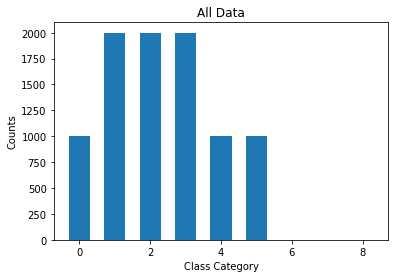

In [7]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
class_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0]
i = 0

all_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height , img_width),
)

for all_img, all_labels in all_data:
    for cat in all_labels:
        class_counts[cat]+=1

print(class_counts)
distribution_data = dict(zip(classes,class_counts))
plt.bar(list(distribution_data.keys()),distribution_data.values(),width =0.6)
plt.title('All Data')
plt.xlabel('Class Category')
plt.ylabel('Counts')
plt.show()


#### Outliers

Originally, the dataset provided 2000 images per class. 1000 images were rgb photos of the fish at different angles, augmented by rotating the images around. The other 1000 images per class were black and white photos of the fish outline. These outline images were removed from the dataset resulting in the useful dataset of 9000 rbg images, with 1000 images per class.

### Visualization of Dataset

Below is visualization of each unique class of the dataset and respective class name. Rotated photos illustrate data augmentation done on original photos.

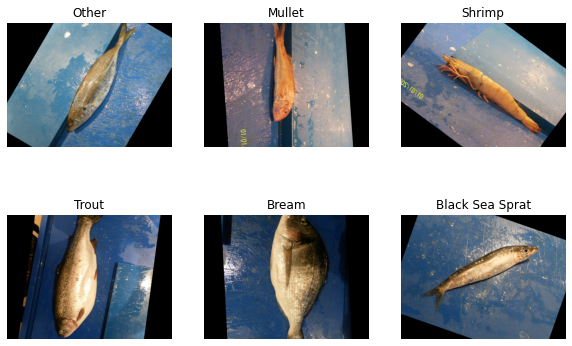

In [8]:
unique = []
i=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for item in range(len(labels)):
        if labels[item] in unique:
            continue
        else:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[item].numpy().astype("uint8"))
            plt.title(class_names[labels[item]])
            plt.axis("off")

            i+=1
            unique.append(labels[item])
        
    break # run only once through a batch

In [9]:
## Reuse model from HW5

alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu",input_shape=[445,590,3] ),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),

    tf.keras.layers.Dense(6, activation='softmax')
])

## compile the basic model

sgd = keras.optimizers.SGD(learning_rate=0.001)
alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])



In [10]:

history = alt_model.fit(
                    train_ds,
                    batch_size=32, 
                    epochs=50,
                    validation_data =test_ds,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 46s 129ms/step - loss: 331.9922 - accuracy: 0.5203 - val_loss: 0.6629 - val_accuracy: 0.8011
Epoch 2/50
225/225 [==============================] - 28s 120ms/step - loss: 0.4403 - accuracy: 0.8774 - val_loss: 0.2187 - val_accuracy: 0.9389
Epoch 3/50
225/225 [==============================] - 27s 120ms/step - loss: 0.2158 - accuracy: 0.9579 - val_loss: 0.1100 - val_accuracy: 0.9667
Epoch 4/50
225/225 [==============================] - 28s 124ms/step - loss: 0.1213 - accuracy: 0.9707 - val_loss: 0.1060 - val_accuracy: 0.9611
Epoch 5/50
225/225 [==============================] - 28s 124ms/step - loss: 0.0955 - accuracy: 0.9756 - val_loss: 0.0812 - val_accuracy: 0.9706
Epoch 6/50
225/225 [==============================] - 29s 125ms/step - loss: 0.0682 - accuracy: 0.9781 - val_loss: 0.1064 - val_accuracy: 0.9739
Epoch 7/50
225/225 [==============================] - 28s 124ms/step - loss: 0.0711 - accuracy: 0.9807 - val_loss: 0.0904 - val_

In [11]:
alt_model.save('baseline_model.h5')

In [12]:
def create_model():
    alt_model = keras.models.Sequential([
    # tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 8, strides=2, activation="relu",input_shape=[445,590,3]),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

    ## compile the basic model

    sgd = keras.optimizers.SGD(learning_rate=0.001)
    alt_model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
              metrics=["accuracy"])
    return alt_model

In [13]:
model1 = create_model()
model2 = create_model()
model3 = create_model()
model4 = create_model()
model5 = create_model()

In [14]:
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size = (img_height , img_width),
    batch_size = batch_size
)

Found 9000 files belonging to 6 classes.


In [15]:
hold1 = full_ds.shard(num_shards=5, index=0)
hold2 = full_ds.shard(num_shards=5, index=1)
hold3 = full_ds.shard(num_shards=5, index=2)
hold4 = full_ds.shard(num_shards=5, index=3)
hold5 = full_ds.shard(num_shards=5, index=4)

train1 = hold2.concatenate(hold3)
train1 = train1.concatenate(hold4)
train1 = train1.concatenate(hold5)
train2 = hold3.concatenate(hold4)
train2 = train2.concatenate(hold5)
train2 = train2.concatenate(hold1)

train3 = hold4.concatenate(hold5)
train3 = train3.concatenate(hold1)
train3 = train3.concatenate(hold2)

train4 = hold5.concatenate(hold1)
train4 = train4.concatenate(hold2)
train4 = train4.concatenate(hold3)

train5 = hold1.concatenate(hold2)
train5 = train5.concatenate(hold3)
train5 = train5.concatenate(hold4)


In [16]:
history1 = model1.fit(
                    train1,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
225/225 [==============================] - 97s 428ms/step - loss: 117749.4688 - accuracy: 0.5238 - val_loss: 0.6726 - val_accuracy: 0.7736
Epoch 2/50
225/225 [==============================] - 97s 431ms/step - loss: 0.7088 - accuracy: 0.8289 - val_loss: 0.9846 - val_accuracy: 0.7325
Epoch 3/50
225/225 [==============================] - 97s 431ms/step - loss: 0.3842 - accuracy: 0.8814 - val_loss: 0.2027 - val_accuracy: 0.9353
Epoch 4/50
225/225 [==============================] - 97s 432ms/step - loss: 0.1904 - accuracy: 0.9356 - val_loss: 0.1694 - val_accuracy: 0.9479
Epoch 5/50
225/225 [==============================] - 97s 428ms/step - loss: 0.1681 - accuracy: 0.9437 - val_loss: 0.5018 - val_accuracy: 0.9567
Epoch 6/50
225/225 [==============================] - 98s 433ms/step - loss: 0.4479 - accuracy: 0.8931 - val_loss: 0.2377 - val_accuracy: 0.9315
Epoch 7/50
225/225 [==============================] - 100s 443ms/step - loss: 0.2797 - accuracy: 0.9362 - val_loss: 0.1293 - 

In [17]:
history2 = model2.fit(
                    train2,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
155/225 [===================>..........] - ETA: 25s - loss: 221.6593 - accuracy: 0.5244

KeyboardInterrupt: 

In [ ]:
history3 = model3.fit(
                    train3,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold3,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 119s 521ms/step - loss: 125.9332 - accuracy: 0.7673 - val_loss: 0.2036 - val_accuracy: 0.9375
Epoch 2/50
226/226 [==============================] - 120s 529ms/step - loss: 0.1440 - accuracy: 0.9653 - val_loss: 0.0651 - val_accuracy: 0.9838
Epoch 3/50
226/226 [==============================] - 118s 520ms/step - loss: 0.5986 - accuracy: 0.9710 - val_loss: 1.1173 - val_accuracy: 0.7790
Epoch 4/50
226/226 [==============================] - 120s 530ms/step - loss: 0.1493 - accuracy: 0.9645 - val_loss: 0.1493 - val_accuracy: 0.9632
Epoch 5/50
226/226 [==============================] - 120s 528ms/step - loss: 0.0886 - accuracy: 0.9813 - val_loss: 0.0647 - val_accuracy: 0.9838
Epoch 6/50
226/226 [==============================] - 119s 526ms/step - loss: 0.0508 - accuracy: 0.9872 - val_loss: 0.1824 - val_accuracy: 0.9554
Epoch 7/50
226/226 [==============================] - 118s 519ms/step - loss: 0.0514 - accuracy: 0.9878 - val_loss: 0.0216

In [ ]:
history4 = model4.fit(
                    train4,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold4,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 118s 519ms/step - loss: 128.8017 - accuracy: 0.7171 - val_loss: 0.4520 - val_accuracy: 0.8895
Epoch 2/50
226/226 [==============================] - 117s 517ms/step - loss: 0.2093 - accuracy: 0.9449 - val_loss: 0.1206 - val_accuracy: 0.9665
Epoch 3/50
226/226 [==============================] - 117s 515ms/step - loss: 0.1027 - accuracy: 0.9666 - val_loss: 0.0618 - val_accuracy: 0.9821
Epoch 4/50
226/226 [==============================] - 120s 530ms/step - loss: 0.0857 - accuracy: 0.9735 - val_loss: 0.1081 - val_accuracy: 0.9827
Epoch 5/50
226/226 [==============================] - 118s 521ms/step - loss: 0.0610 - accuracy: 0.9885 - val_loss: 0.0187 - val_accuracy: 0.9961
Epoch 6/50
226/226 [==============================] - 120s 528ms/step - loss: 0.0283 - accuracy: 0.9926 - val_loss: 0.0120 - val_accuracy: 0.9989
Epoch 7/50
226/226 [==============================] - 118s 521ms/step - loss: 0.0160 - accuracy: 0.9969 - val_loss: 0.0095

In [ ]:
history5 = model5.fit(
                    train5,
                    batch_size=32, 
                    epochs=50,
                    validation_data =hold5,
                    callbacks=[keras.callbacks.EarlyStopping(monitor="accuracy",min_delta=0.005,patience=2)])

Epoch 1/50
226/226 [==============================] - 120s 529ms/step - loss: 180.4890 - accuracy: 0.7553 - val_loss: 0.1661 - val_accuracy: 0.9531
Epoch 2/50
226/226 [==============================] - 122s 541ms/step - loss: 0.1432 - accuracy: 0.9617 - val_loss: 0.0792 - val_accuracy: 0.9777
Epoch 3/50
226/226 [==============================] - 121s 533ms/step - loss: 0.0826 - accuracy: 0.9757 - val_loss: 0.0658 - val_accuracy: 0.9849
Epoch 4/50
226/226 [==============================] - 117s 517ms/step - loss: 0.0730 - accuracy: 0.9846 - val_loss: 0.0512 - val_accuracy: 0.9816
Epoch 5/50
226/226 [==============================] - 118s 520ms/step - loss: 0.0415 - accuracy: 0.9893 - val_loss: 0.0158 - val_accuracy: 0.9961
Epoch 6/50
226/226 [==============================] - 115s 511ms/step - loss: 0.0344 - accuracy: 0.9896 - val_loss: 0.0812 - val_accuracy: 0.9810


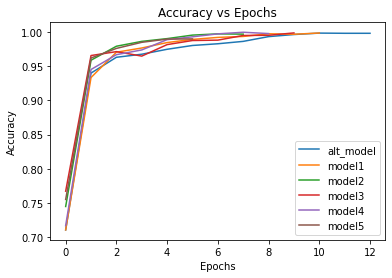

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.plot(history5.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

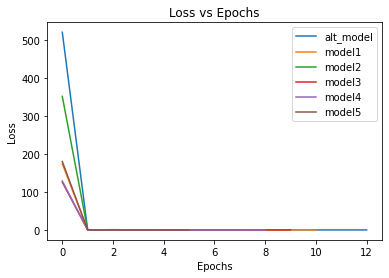

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

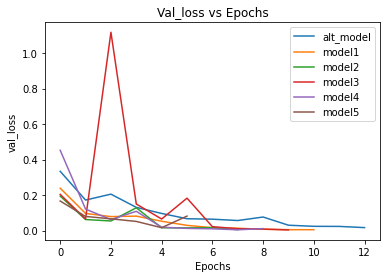

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.title('Val_loss vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

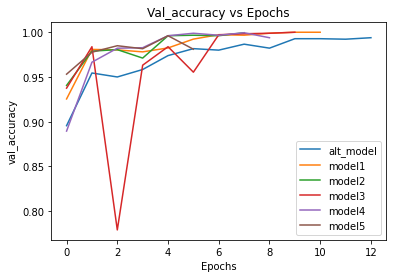

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('val_accuracy')
plt.title('Val_accuracy vs Epochs')
plt.legend(['alt_model','model1','model2','model3','model4','model5'])

In [ ]:
 model1.save('model1_drop.h5')
 model2.save('model2_drop.h5')
 model3.save('model3_drop.h5')
 model4.save('model4_drop.h5')
 model5.save('model5_drop.h5')

NameError: name 'model1' is not defined